In [1]:
!pip install sklearn_crfsuite

In [2]:
from nltk.corpus import conll2002
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron, SGDClassifier, RidgeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import string
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import sklearn_crfsuite
import sklearn_crfsuite.metrics
import pickle
import numpy as np
from sklearn.metrics import f1_score
from nltk.corpus.reader import ConllCorpusReader
import nltk
import matplotlib.pyplot as plt
import math
import nltk
from nltk.classify import MaxentClassifier

from collections import Counter

nltk.download('conll2002')

regex = re.compile(
        r'^(?:http|ftp)s?://'  # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|'  # domain...
        r'localhost|'  # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'  # ...or ip
        r'(?::\d+)?'  # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)

def wordshape(text):

    t1 = re.sub('[A-Z]', 'X',text)
    t2 = re.sub('[a-z]', 'x', t1)
    return re.sub('[0-9]', 'd', t2)

def getfeats(word, o):
    """ This takes the word in question and
    the offset with respect to the instance
    word """
    features = [
        (str(o) + 'word', word)
        # TODO: add more features here.
    ]
    return features

def gettag(tag, o):
    features = [ (str(o) +"tag", tag) ]
    return features

def gethyphen(word, o):
    if('-' in word):
        features = [(str(o) +"hyphen", 1)]
    else:
        features = [(str(o) +"hyphen", 0)]
    return features
    
def capletter(word, o):
    if(word[0].isupper):
        features = [(str(o) +"first_upper", 1)]
    else:
        features = [(str(o) +"first_upper", 0)]
    return features

def noun_suffix(word, o):
    if(word.endswith('o') or word.endswith('or') or word.endswith('a') or word.endswith('ora')):
        features = [(str(o) +"common_suffix", 1)]
    else:
        features = [(str(o) +"common_suffix", 0)]
    return features

def get_wordshape(word, o):
    feature = [(str(o) +"word_shape", wordshape(word))]
    return feature

def all_upper(word, o):
    if(word.isupper()):
        return [(str(o) +"all_upper", 1)]
    else:
        return [(str(o) +"all_upper", 0)]

def all_lower(word, o):
    if(word.islower()):
        return [(str(o) +"all_lower", 1)]
    else:
        return [(str(o) +"all_lower", 0)]

def has_apostrophe(word, o):
    if("'" in word):
        return [(str(o) +"apostrophe", 1)]
    else:
        return [(str(o) +"apostrophe", 0)]

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def special_characters(word, o):
    if(isEnglish(word)):
        return [(str(o) +"special_characters", 0)]
    else:
        return [(str(o) +"special_characters", 1)]

def onlynum(word, o):
    if(word.isdigit()):
        return [(str(o) +"onlynum", 1)]
    else:
        return [(str(o) +"onlynum", 0)]

def contains_num(word, o):
    if(any(char.isdigit() for char in word)):
        return [(str(o) +"contains_num", 1)]
    else:
        return [(str(o) +"contains_num", 0)]

def ending_fullstop(word, o):
    if(word[-1] == '.'):
        return [(str(o) +"fullstop", 1)]
    else:
        return [(str(o) +"fullstop", 0)]

def minlen(word, o):
    if(len(word)>=2):
        return [(str(o) +"minlen", 1)]
    else:
        return [(str(o) +"minlen", 0)]

def punctuation(word, o):
    for i in word: 
      if i in string.punctuation: 
        return [(str(o) +"punctuation", 1)]
    return [(str(o) +"punctuation", 0)]

def all_punctuation(word, o):
    count = 0
    for i in word: 
      if i in string.punctuation: 
        count = count +1
    if(count == len(word)):
        return [(str(o) +"punctuation", 1)]
    else:
        return [(str(o) +"punctuation", 0)]

def is_stopword(word, o):
    stop_words = set(stopwords.words('spanish'))
    if(word in stop_words):
        return([(str(o) +"is_stop", 1)])
    else:
        return([(str(o) +"is_stop", 0)])


def isRomanNumeral(word, o):
    numeral = word.upper()
    validRomanNumerals = ["M", "D", "C", "L", "X", "V", "I"]
    for letters in numeral:
        if letters not in validRomanNumerals:
            return ([(str(o) +"is_roman", 0)])

    return ([(str(o) + "is_roman", 1)])


def contains_dots(word, o):
    if word.find('.')==-1:
        return ([(str(o) + "has_dot", 0)])

    return ([(str(o) + "has_dot", 1)])


def single_char(word, o):
    if len(word)==1:
        return ([(str(o) + "is_char", 1)])

    return ([(str(o) + "is_char", 0)])

def is_url(word, o):
    if re.match(regex, word) is not None:
        return ([(str(o) + "is_url", 1)])
    return ([(str(o) + "is_url", 0)])


def word2features(sent, i):
    """ The function generates all features
    for the word at position i in the
    sentence."""
    features = []
    # the window around the token
    for o in [-4,-3, -2,-1,0,1,2, 3, 4]:
        if i+o >= 0 and i+o < len(sent):
            word = sent[i+o][0]
            tag = sent[i+o][1]
            featlist = getfeats(word, o)
            features.extend(featlist)
            featlist = gettag(tag, o)
            features.extend(featlist)

            featlist = gethyphen(word, o)
            features.extend(featlist)

            featlist = capletter(word, o)
            features.extend(featlist)

            featlist = noun_suffix(word, o)
            features.extend(featlist)

            featlist = get_wordshape(word, o)
            features.extend(featlist)

            featlist = all_upper(word, o)
            features.extend(featlist)

            featlist = all_lower(word, o)
            features.extend(featlist)

            featlist = has_apostrophe(word, o)
            features.extend(featlist)

            featlist = special_characters(word, o)
            features.extend(featlist)

            featlist = onlynum(word, o)
            features.extend(featlist)

            featlist = contains_num(word, o)
            features.extend(featlist)

            featlist = ending_fullstop(word, o)
            features.extend(featlist)

            featlist = isRomanNumeral(word, o)
            features.extend(featlist)

            featlist = contains_dots(word, o)
            features.extend(featlist)

            featlist = single_char(word, o)
            features.extend(featlist)

            featlist = is_url(word, o)
            features.extend(featlist)

    
    word = sent[i][0]
    tag = sent[i][1]

    features.extend([("word_lower", word.lower())])

    features.extend([("word_len", len(word))])

    if (i == 0):
        features.extend([("firstword", 1)])
    else:
        features.extend([("firstword", 0)])

    features.extend([("bias", 1)])
    
    return dict(features)


[nltk_data] Downloading package conll2002 to /root/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = ConllCorpusReader('/content/drive/My Drive/CoNLL-2003', 'eng.train', ['words', 'pos', 'ignore', 'chunk'])
dev = ConllCorpusReader('/content/drive/My Drive/CoNLL-2003', 'eng.testa', ['words', 'pos', 'ignore', 'chunk'])
test = ConllCorpusReader('/content/drive/My Drive/CoNLL-2003', 'eng.testb', ['words', 'pos', 'ignore', 'chunk'])

train_sents = list(train.iob_sents())
dev_sents = list(dev.iob_sents())
test_sents = list(test.iob_sents())

In [5]:
len(train_sents)

14987

In [0]:
unannotated_dataset = list(train.iob_sents())

In [0]:
X_train = []
train_labels = []

for sent in unannotated_dataset:
    unannotated_dataset_feats = []
    unannotated_dataset_labels = []

    for i in range(len(sent)):
        feats = word2features(sent, i)   
        unannotated_dataset_feats.append(feats)
        unannotated_dataset_labels.append(sent[i][-1])

    X_train.append(unannotated_dataset_feats)
    train_labels.append(unannotated_dataset_labels)

ind_select=np.array([len(y)>0 for y in X_train])
X_train = np.array(X_train)[ind_select]
train_labels = np.array(train_labels)[ind_select]

In [0]:
test_feats = []
test_labels = []

# for sent in test_sents:
#     for i in range(len(sent)):
#         feats = word2features(sent, i)
#         test_feats.append(feats)
#         test_labels.append(sent[i][-1])


for sent in test_sents:
    test_sents_feats = []
    test_sents_labels = []

    for i in range(len(sent)):
        feats = word2features(sent, i)   
        test_sents_feats.append(feats)
        test_sents_labels.append(sent[i][-1])

    test_feats.append(test_sents_feats)
    test_labels.append(test_sents_labels)

ind_select=np.array([len(y)>0 for y in test_feats])
test_feats = np.array(test_feats)[ind_select]
test_labels = np.array(test_labels)[ind_select]

In [0]:
initial_size_of_training_set = 20

training_dataset_feats = {}
training_dataset_labels = {}

all_length=np.array([len(X_train[i]) for i in range(len(X_train))])

indices=all_length.argsort()[-initial_size_of_training_set:][::-1]


training_dataset_feats = list(X_train[indices])
training_dataset_labels =  list(train_labels[indices])

X_train = np.delete(X_train, indices)
train_labels = np.delete(train_labels, indices)

In [0]:
X_train_random=X_train.copy()
train_labels_random=train_labels.copy()

In [0]:
initial_training_dataset_feats=training_dataset_feats.copy()
initial_training_dataset_labels=training_dataset_labels.copy()

In [12]:
X_train.shape, train_labels.shape

((14021,), (14021,))

In [0]:

# X_train = X_train[0:10000]
# train_labels = train_labels[0:10000]

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


In [0]:
# prediction_of_classifier[1][0]

In [0]:
# crf.predict_marginals_single(X_train[1])

In [16]:

labels_predicted_for_unannotated_data = []

print("SIZE OF TRAINING DATASET ",len(training_dataset_feats))
crf.fit(training_dataset_feats,training_dataset_labels)
prediction_of_classifier=crf.predict(X_train)

SIZE OF TRAINING DATASET  20


In [0]:
# def get_uncertainy_of_predicted_values(X_train,crf,prediction_of_classifier,n):
#     uncertainity_value_all_predictions=[]
#     for sent in range(len(X_train)):
#         uncertainity_value=0
#         li=[]
#         for words in range(len(X_train[sent])):
#             li.append(crf.predict_marginals_single(X_train[sent])[words][prediction_of_classifier[sent][words]])
#         li=np.array(li)
#         ind=li.argsort()[:n]

        
#         uncertainity_value=sum(1-li[ind])/(len(X_train[sent])+0.0005)
#         uncertainity_value_all_predictions.append(uncertainity_value)
#     return uncertainity_value_all_predictions


def get_uncertainy_of_predicted_values(X_train,crf):

    uncertainity_value_all_predictions=[]
    for sent in range(len(X_train)):
        uncertainity_value=0
        kk=crf.predict_marginals_single(X_train[sent])
        uncertainity_value=sum([1-max(kk[i].values()) for i in range(len(X_train[sent]))])        
        uncertainity_value=uncertainity_value/(len(X_train[sent]))
        uncertainity_value_all_predictions.append(uncertainity_value)

    return uncertainity_value_all_predictions



In [ ]:
def get_total_token_entropy(X_train,crf):

    entropy_value_all_predictions=[]
    for sent in range(len(X_train)):
        sentence_entropy_value=0.0
        kk=crf.predict_marginals_single(X_train[sent])
        for i in range(len(X_train[sent])):
            probs = np.array(list(kk[i].values()))
            entropy = -np.sum(porbs*np.log2(probs))
            sentence_entropy_value += entropy
            
        entropy_value_all_predictions.append(sentence_entropy_value)

    return uncertainity_value_all_predictions

In [0]:
# sent=1
# kk=crf.predict_marginals_single(X_train[sent])
# # 1-max(kk[0].values())

# sum([1-max(kk[0].values()) for i in range(len(X_train[sent]))])

# [1-max(kk[i].values()) for i in range(len(X_train[sent]))]

In [0]:
# sent=1
# uncertainity_value=0
# for words in range(len(X_train[sent])):
#     print((1-crf.predict_marginals_single(X_train[sent])[words][prediction_of_classifier[sent][words]]))
#     uncertainity_value=uncertainity_value+(1-crf.predict_marginals_single(X_train[sent])[words][prediction_of_classifier[sent][words]])
      

In [0]:
# len(training_dataset_feats),len(training_dataset_labels)
# m=np.array([1,3,2])
# np.argsort(m)

In [21]:
i=3
n=12
iter_count=0
sub_sample=20
F_SCORE_TEST=[]
NUMBER_OF_DATA=[]
while(len(X_train)):
    if iter_count>=120:
        sub_sample=200

    uncertainity_value_all_predictions=get_total_token_entropy(X_train,crf)
    indices_of_most_confused_sentences = np.argsort(uncertainity_value_all_predictions)[-sub_sample:]
    training_dataset_feats.extend(X_train[indices_of_most_confused_sentences])
    training_dataset_labels.extend(train_labels[indices_of_most_confused_sentences])

    X_train = np.delete(X_train, indices_of_most_confused_sentences)
    train_labels = np.delete(train_labels, indices_of_most_confused_sentences)
    print(X_train.shape)
    crf.fit(training_dataset_feats,training_dataset_labels)
    prediction_of_classifier=crf.predict(X_train)  

    test_pred = crf.predict(test_feats)
    NUMBER_OF_DATA.append(len(training_dataset_feats))
    fscore_value=sklearn_crfsuite.metrics.flat_f1_score(test_labels, test_pred, average="macro")
    F_SCORE_TEST.append(fscore_value)
    print("n = ",NUMBER_OF_DATA[-1],"f1 score ",fscore_value)
    
    with open("TTE_english.txt", "a") as f:
        f.write(str(len(training_dataset_feats[0])) + " " + str(fscore_value)+"\n")

    i=i+1
    iter_count=iter_count+1



(14001,)
n =  40 f1 score  0.2640007381418244
(13981,)
n =  60 f1 score  0.28620406771097406
(13961,)
n =  80 f1 score  0.2868737515687648
(13941,)
n =  100 f1 score  0.3121488077415798
(13921,)
n =  120 f1 score  0.3276836120636454
(13901,)
n =  140 f1 score  0.33561429190493197
(13881,)
n =  160 f1 score  0.3363856672386245
(13861,)
n =  180 f1 score  0.33676584365921947
(13841,)
n =  200 f1 score  0.3400477203983501
(13821,)
n =  220 f1 score  0.35433236456931433
(13801,)
n =  240 f1 score  0.3565521022870182
(13781,)
n =  260 f1 score  0.36252977827309996
(13761,)
n =  280 f1 score  0.3613557132080454
(13741,)
n =  300 f1 score  0.3642931292565905
(13721,)
n =  320 f1 score  0.36636658824990437
(13701,)
n =  340 f1 score  0.3747392939701788
(13681,)
n =  360 f1 score  0.37595226648963176
(13661,)
n =  380 f1 score  0.3765374808175796
(13641,)
n =  400 f1 score  0.38286808770512953
(13621,)
n =  420 f1 score  0.38571937971837644
(13601,)
n =  440 f1 score  0.3816505640034902
(13581,

#### RANDOM

In [0]:

X_train_random_s = X_train_random.copy()
train_labels_random_s = train_labels_random.copy()

In [0]:
initial_size_of_training_set = 20

# training_dataset_feats = {}
# training_dataset_labels = {}

# indices=np.random.randint(0, X_train_random_s.shape[0], size=initial_size_of_training_set)
# training_dataset_feats = list(X_train_random_s[indices])
# training_dataset_labels =  list(train_labels_random_s[indices])

training_dataset_feats=initial_training_dataset_feats.copy()
training_dataset_labels=initial_training_dataset_labels.copy()

X_train = X_train_random_s
train_labels = train_labels_random_s

In [24]:
len(training_dataset_feats)

20

In [0]:

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


In [0]:
# prediction_of_classifier[1][0]

In [0]:
# crf.predict_marginals_single(X_train[1])

In [28]:

labels_predicted_for_unannotated_data = []

print("SIZE OF TRAINING DATASET ",len(training_dataset_feats))
crf.fit(training_dataset_feats,training_dataset_labels)
prediction_of_classifier=crf.predict(X_train)

SIZE OF TRAINING DATASET  20


In [29]:
len(training_dataset_feats),len(training_dataset_labels)

(20, 20)

In [30]:
X_train.shape


(14021,)

In [31]:
i=3
F_SCORE_TEST_RANDOM=[]
NUMBER_OF_DATA_RANDOM=[]
sub_sample=20
iter_count=0
while(len(X_train)):
    if iter_count>=120:
        sub_sample=200
    ind_random=np.random.randint(0,len(X_train), size=sub_sample)

  
    training_dataset_feats.extend(X_train[ind_random])
    training_dataset_labels.extend(train_labels[ind_random])

    X_train = np.delete(X_train, ind_random)
    train_labels = np.delete(train_labels, ind_random)
    print(X_train.shape)

    crf.fit(training_dataset_feats,training_dataset_labels)
    # prediction_of_classifier=crf.predict(X_train)  

    test_pred = crf.predict(test_feats)
    NUMBER_OF_DATA_RANDOM.append(len(training_dataset_feats))
    fscore_value=sklearn_crfsuite.metrics.flat_f1_score(test_labels, test_pred, average="macro")
    F_SCORE_TEST_RANDOM.append(fscore_value)
    print("n = ",NUMBER_OF_DATA_RANDOM[-1],"f1 score ",fscore_value)
    
    with open("TTE_english.txt", "a") as f:
        f.write(str(len(training_dataset_feats[0])) + " " + str(fscore_value)+"\n")


    i=i+1
    iter_count=iter_count+1


(14001,)
n =  40 f1 score  0.3414387960625748
(13981,)
n =  60 f1 score  0.363530005797776
(13961,)
n =  80 f1 score  0.37326053546193305
(13941,)
n =  100 f1 score  0.3923965516727158
(13921,)
n =  120 f1 score  0.3990002348129169
(13901,)
n =  140 f1 score  0.4046730030262841
(13881,)
n =  160 f1 score  0.4104525301404248
(13861,)
n =  180 f1 score  0.41464772443300724
(13841,)
n =  200 f1 score  0.42189815022861926
(13821,)
n =  220 f1 score  0.42248516917896484
(13801,)
n =  240 f1 score  0.4214465515678066
(13781,)
n =  260 f1 score  0.4248528653540668
(13761,)
n =  280 f1 score  0.42538869827178455
(13741,)
n =  300 f1 score  0.4255336386979275
(13721,)
n =  320 f1 score  0.4244682481315401
(13701,)
n =  340 f1 score  0.43121632393157455
(13681,)
n =  360 f1 score  0.43089664597902927
(13661,)
n =  380 f1 score  0.4332549381766829
(13641,)
n =  400 f1 score  0.4341056941101384
(13621,)
n =  420 f1 score  0.4324158333463065
(13601,)
n =  440 f1 score  0.43688346737155037
(13581,)


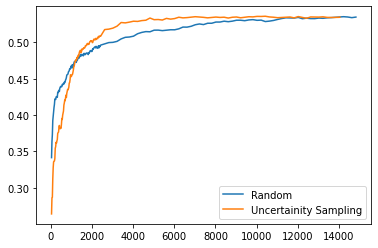

In [33]:
plt.plot(NUMBER_OF_DATA_RANDOM,F_SCORE_TEST_RANDOM,label='Random')
plt.plot(NUMBER_OF_DATA,F_SCORE_TEST,label='Uncertainity Sampling') 
plt.legend()

plt.show()